# _Set Up and Data Processing_ 

(Thursday June 27, 2019)

In [37]:
from capstone import data
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback

In [38]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [39]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [40]:
# take 100% of data with seed of 8 and a single pathology, Atelectasis
train_df, valid_df = data.data_processing(path, 'Atelectasis', 8, 1);

(223414, 19)
(234, 19)
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed.
------------------------------
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
------------------------------

Atelectasis
------------------------------
Training shape
(223414, 2)

Validation shape
(234, 2)


In [41]:
train_df.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00001/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,-1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,0.0
5,CheXpert-v1.0-small/train/patient00004/study1/...,0.0
6,CheXpert-v1.0-small/train/patient00004/study1/...,0.0
7,CheXpert-v1.0-small/train/patient00005/study1/...,0.0
8,CheXpert-v1.0-small/train/patient00005/study1/...,0.0
9,CheXpert-v1.0-small/train/patient00005/study2/...,0.0


In [42]:
train_df['Atelectasis'].value_counts()

 0.0    156299
-1.0     33739
 1.0     33376
Name: Atelectasis, dtype: int64

In [43]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# _U-Ones: Relabel Uncertain (-1) Labels as Positive Labels (1)_

In [44]:
train_df = train_df.replace(-1, 1)

In [45]:
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [46]:
train_df['Atelectasis'].value_counts()

0    156299
1     67115
Name: Atelectasis, dtype: int64

In [47]:
33739 + 33376

67115

# _Set Up for DL Training_

In [48]:
# default transformations
tfms = get_transforms()

In [49]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [50]:
src = src.split_by_rand_pct(0.2)

In [51]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 6114MB of GPU RAM free


In [52]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=64)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

data.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [53]:
print(data.c)
print(data.classes)

2
[0, 1]


In [54]:
data

ImageDataBunch;

Train: LabelList (178732 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,1,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (44682 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

In [55]:
# create a pretrained resnet152 cnn_learner with error rate and AUROC as the metrics with a ps of 0.5 (i.e. 50% of randomly selected neurons will be ignored from the n-1 layer) and batch normalization
learn = cnn_learner(data=data, base_arch=models.resnet152, metrics=[error_rate, AUROC()], pretrained=True,
                     ps=0.5, bn_final=True)

In [26]:
# load weights from previous best performing model
learn.load('trial14-rd3-atelectasis-fulldata');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.77E-07
Min loss divided by 10: 4.79E-04


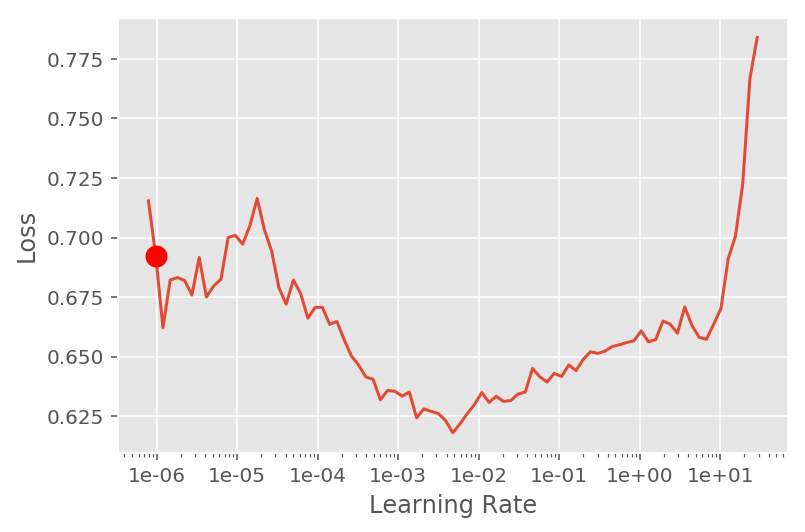

In [27]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [28]:
lr = (1e-4 + 1e-3) / 2
lr

0.00055

In [29]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# _Rd. 1 Training_

In [33]:
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.602095,0.592177,0.302404,0.624381,32:36
1,0.583299,0.591218,0.302381,0.628136,29:48
2,0.594840,0.590666,0.302381,0.629044,29:48
3,0.584220,0.590582,0.302269,0.631151,30:06


Epoch 4: early stopping


In [34]:
learn.save('trial15-rd1')

# _Rd. 2 Training_

In [57]:
# continue here on June 28
learn.load('trial15-rd1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-06
Min loss divided by 10: 5.13E-07


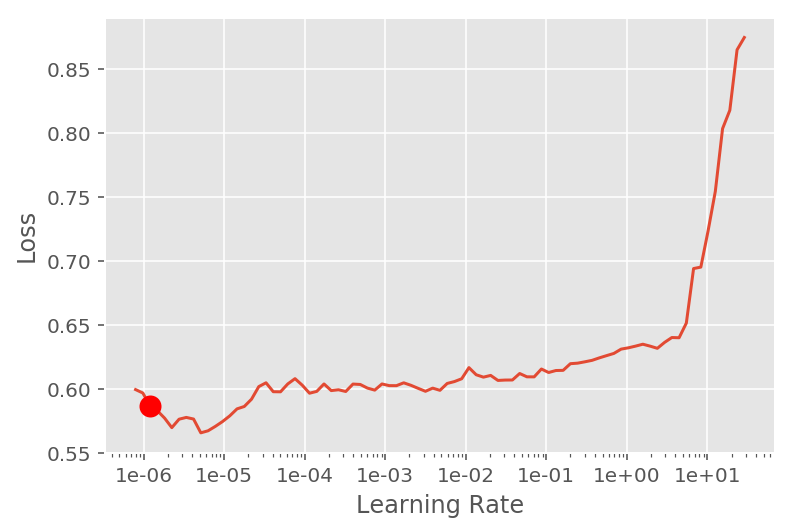

In [58]:
# unfreeze all layers
learn.unfreeze()

learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, slice(1e-06), callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

# _Resize Images to 128_

In [43]:
data2 = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=128)
        .databunch(bs = bs)
        .normalize(imagenet_stats))
data2.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [44]:
print(data.c)
print(data.classes)

2
[0, 1]


In [45]:
learn.data = data2

In [46]:
data2

ImageDataBunch;

Train: LabelList (17811 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,1,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (4452 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 1.20E-07


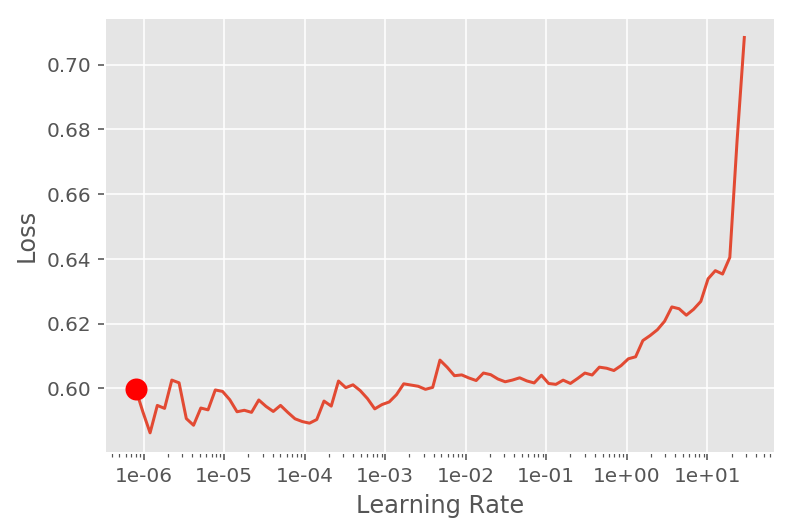

In [47]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [48]:
learn.freeze()
lr = 1e-4
lr

0.0001

In [49]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.594792,0.772704,0.300090,0.574439,02:38
1,0.600147,1.647887,0.302785,0.571127,02:39
2,0.597461,1.377266,0.302785,0.572627,02:38
3,0.604820,0.895563,0.300764,0.575703,02:39
4,0.591868,0.995782,0.302561,0.572873,02:38


In [54]:
learn.save('trial15-rd2')

# _Resize Images to 224 & Decrease Batch Size to 16_

In [50]:
data3 = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = 16)
        .normalize(imagenet_stats))
data3.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [51]:
print(data3.c)
print(data3.classes)

2
[0, 1]


In [52]:
learn.data = data3

In [53]:
data3

ImageDataBunch;

Train: LabelList (17811 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (4452 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.82E-07


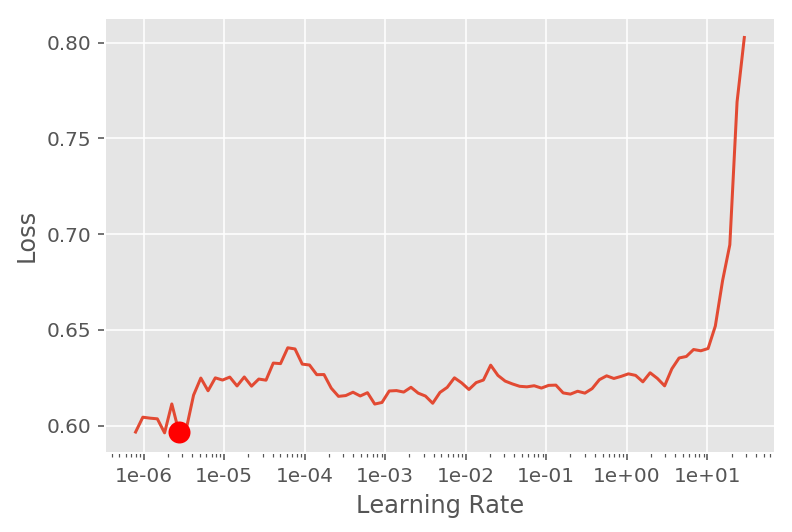

In [55]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [57]:
learn.freeze()
lr = learn.recorder.min_grad_lr
lr

2.7542287033381663e-06